
# Forecasting Analysis

In this notebook we forecast the next six months of sales for the top products in the portfolio. We compare a classical time‑series baseline (SARIMA) with a machine learning model (XGBoost) that leverages the engineered features. The focus is on generating both point forecasts and error metrics so that business users can gauge model reliability.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

agg_path = Path('..') / 'data' / 'processed' / 'sales_tableau.csv'
agg_df = pd.read_csv(agg_path, parse_dates=['month'])

# Identify top 10 products by total sales
top_products = (
    agg_df.groupby('product_id')['total_sales']
    .sum()
    .nlargest(10)
    .index
    .tolist()
)
print('Top products:', top_products)


Top products: ['GEN-64', 'GEN-55', 'M01AE-03', 'M01AB-01', 'M01AB-03', 'M01AB-02', 'N05C-03', 'R03-03', 'M01AE-08', 'R03-02']


In [2]:

def sarima_forecast(ts, steps=6):
    model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    forecast = res.forecast(steps=steps)
    return forecast

import pandas as pd

# XGBoost forecasting with iterative horizon
def xgb_forecast(product_df, steps=6):
    product_df = product_df.sort_values('month').reset_index(drop=True)
    df_feat = product_df.copy()
    for lag in [1,3,6]:
        df_feat[f'lag_{lag}'] = df_feat['total_sales'].shift(lag)
    for window in [3,6]:
        df_feat[f'rolling_{window}'] = df_feat['total_sales'].shift(1).rolling(window).mean()
    df_feat['month_num'] = df_feat['month'].dt.month
    df_feat['year'] = df_feat['month'].dt.year
    feature_cols = ['lag_1','lag_3','lag_6','rolling_3','rolling_6','promo_days','avg_unit_price','month_num','year']

    df_model = df_feat.dropna(subset=feature_cols + ['total_sales']).reset_index(drop=True)
    test_size = min(6, len(df_model) // 5)
    train_df = df_model.iloc[:-test_size]
    test_df = df_model.iloc[-test_size:]

    X_train = train_df[feature_cols]
    y_train = train_df['total_sales']
    X_test = test_df[feature_cols]
    y_test = test_df['total_sales']

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )
    model.fit(X_train, y_train)

    # Predictions for hold‑out
    pred_test = pd.Series(model.predict(X_test), index=test_df['month'])

    # Iterative forecast
    history = df_feat[['month','total_sales','promo_days','avg_unit_price']].copy()
    last_date = history['month'].max()
    future_preds = []
    for step in range(steps):
        next_month = last_date + pd.DateOffset(months=1)
        # Build feature row
        sales_series = history['total_sales']
        temp = {
            'month': next_month,
            'promo_days': history['promo_days'].iloc[-1],
            'avg_unit_price': history['avg_unit_price'].iloc[-1],
            'lag_1': sales_series.iloc[-1],
            'lag_3': sales_series.iloc[-3] if len(sales_series) >= 3 else sales_series.iloc[-1],
            'lag_6': sales_series.iloc[-6] if len(sales_series) >= 6 else sales_series.iloc[-1],
            'rolling_3': sales_series.iloc[-3:].mean() if len(sales_series) >= 3 else sales_series.mean(),
            'rolling_6': sales_series.iloc[-6:].mean() if len(sales_series) >= 6 else sales_series.mean(),
            'month_num': next_month.month,
            'year': next_month.year,
        }
        X_new = pd.DataFrame([temp])[feature_cols]
        pred_value = model.predict(X_new)[0]
        future_preds.append((next_month, pred_value))
        # Append predicted row to history using concat
        new_row = pd.DataFrame({
            'month': [next_month],
            'total_sales': [pred_value],
            'promo_days': [temp['promo_days']],
            'avg_unit_price': [temp['avg_unit_price']]
        })
        history = pd.concat([history, new_row], ignore_index=True)
        last_date = next_month

    return pred_test, pd.Series(dict(future_preds))


In [3]:

results = []
forecast_dir = Path('..') / 'data' / 'processed'
forecast_dir.mkdir(parents=True, exist_ok=True)

for pid in top_products:
    prod_df = agg_df[agg_df['product_id'] == pid][['month','total_sales','promo_days','avg_unit_price']].copy()
    prod_df = prod_df.sort_values('month')
    if len(prod_df) < 18:
        continue
    ts = prod_df.set_index('month')['total_sales']
    # SARIMA baseline
    sarima_pred = sarima_forecast(ts.iloc[:-6], steps=6)
    sarima_pred.index = ts.index[-6:]
    sarima_mape = mean_absolute_percentage_error(ts.iloc[-6:], sarima_pred)
    # XGBoost model
    xgb_pred_test, xgb_future = xgb_forecast(prod_df, steps=6)
    # Compute MAPE on the hold‑out part using actual last observations
    actual_test = ts.iloc[-len(xgb_pred_test):]
    xgb_mape = mean_absolute_percentage_error(actual_test, xgb_pred_test)
    # Build forecast DataFrame
    forecast_df = pd.DataFrame({
        'month': list(ts.index[-len(xgb_pred_test):]) + [d for d in xgb_future.index],
        'actual': list(ts.iloc[-len(xgb_pred_test):]) + [np.nan] * len(xgb_future),
        'sarima_pred': list(sarima_pred.values[-len(xgb_pred_test):]) + [np.nan] * len(xgb_future),
        'xgb_pred': list(xgb_pred_test.values) + list(xgb_future.values)
    })
    forecast_path = forecast_dir / f"forecast_{pid}.csv"
    forecast_df.to_csv(forecast_path, index=False)
    results.append({
        'product_id': pid,
        'sarima_mape': sarima_mape,
        'xgb_mape': xgb_mape,
        'forecast_path': str(forecast_path)
    })
results_df = pd.DataFrame(results).sort_values('xgb_mape')
results_df


,product_id,sarima_mape,xgb_mape,forecast_path
0,GEN-64,0.081866,0.101546,../data/processed/forecast_GEN-64.csv
4,M01AB-03,0.135532,0.119652,../data/processed/forecast_M01AB-03.csv
1,GEN-55,0.133795,0.145836,../data/processed/forecast_GEN-55.csv
2,M01AE-03,0.116137,0.159595,../data/processed/forecast_M01AE-03.csv
5,M01AB-02,0.352169,0.266513,../data/processed/forecast_M01AB-02.csv
6,N05C-03,0.318044,0.281327,../data/processed/forecast_N05C-03.csv
3,M01AB-01,0.260796,0.284277,../data/processed/forecast_M01AB-01.csv
9,R03-02,0.360985,0.344093,../data/processed/forecast_R03-02.csv
8,M01AE-08,0.395747,0.385451,../data/processed/forecast_M01AE-08.csv
7,R03-03,0.614412,0.547768,../data/processed/forecast_R03-03.csv


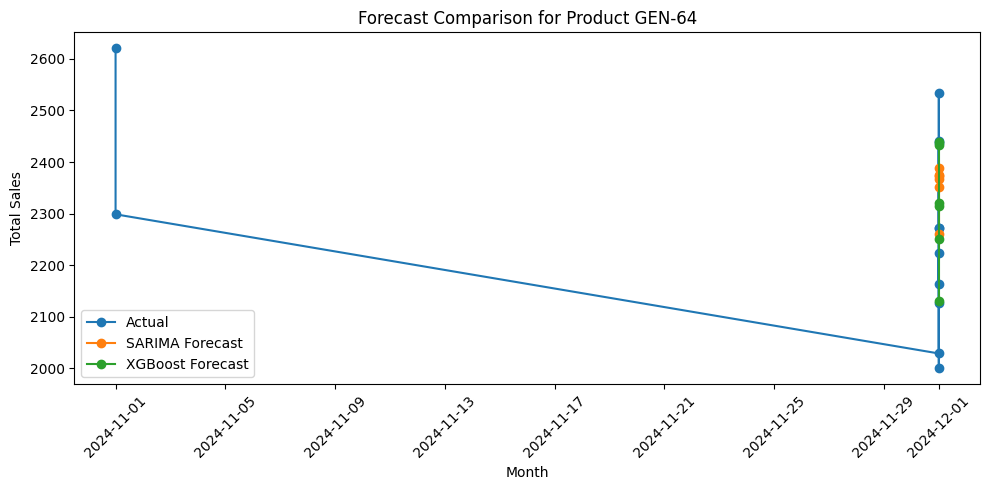

In [4]:

# Plot comparison for product with lowest XGB MAPE
if not results_df.empty:
    example_pid = results_df.iloc[0]['product_id']
    prod_df = agg_df[agg_df['product_id'] == example_pid].sort_values('month')
    ts = prod_df.set_index('month')['total_sales']

    sarima_pred = sarima_forecast(ts.iloc[:-6], steps=6)
    sarima_pred.index = ts.index[-6:]
    xgb_pred_test, xgb_future = xgb_forecast(prod_df, steps=6)

    plt.figure(figsize=(10,5))
    plt.plot(ts.index[-12:], ts.iloc[-12:], label='Actual', marker='o')
    plt.plot(sarima_pred.index, sarima_pred, label='SARIMA Forecast', marker='o')
    plt.plot(xgb_pred_test.index, xgb_pred_test, label='XGBoost Forecast', marker='o')
    plt.title(f'Forecast Comparison for Product {example_pid}')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



The table above lists the Mean Absolute Percentage Error (MAPE) for the SARIMA and XGBoost models on each of the top products. Lower values indicate better predictive performance. The accompanying plot illustrates actual versus predicted sales for the best‑performing product (in terms of XGBoost MAPE) over the final twelve months of the sample.
